# TEXT CAPTCHA PROJECT

## Imports and Dataset

In [ ]:
!pip install pytesseract pillow opencv-python

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import optim
from tqdm import tqdm
from PIL import Image, ImageDraw
import string
from torch.nn.functional import one_hot
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

outer sample ex width:  200 height:  50


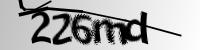

inner sample ex width:  200 height:  50


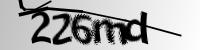

In [3]:
image_path = './final_project_data/samples/226md.png'
image = Image.open(image_path)
width, height = image.size
print("outer sample ex width: ", width, "height: ", height)
image.show()

#check the size of the image in the inner file
image_path = './final_project_data/samples/samples/226md.png'
image = Image.open(image_path)
width, height = image.size
print("inner sample ex width: ", width, "height: ", height)
image.show()

In [4]:
# Make sure the two sample folders have the same files, if so we can just use one of the folders
outer_samples_path = './final_project_data/samples/'
inner_samples_path = './final_project_data/samples/samples/'

# List all files in each folder and filter for PNG files
outer_samples = {file for file in os.listdir(outer_samples_path) if file.endswith('.png')}
inner_samples = {file for file in os.listdir(inner_samples_path) if file.endswith('.png')}

# Compare the sets of files
if outer_samples == inner_samples:
    print("Both folders contain the same PNG files.")
else:
    print("The folders do not have the same PNG files.")

Both folders contain the same PNG files.


In [5]:
def add_whitespace(image_path, border_size):
    # Sample colors at the corners or edges
    img = Image.open(image_path)
    left_color = img.getpixel((0, 0))
    right_color = img.getpixel((img.width - 1, img.height - 1))

    new_size = (img.width + 2 * border_size, img.height)
    new_img = Image.new(img.mode, new_size)

    # Create a draw object
    draw = ImageDraw.Draw(new_img)

    # Draw a rectangle of the left color
    draw.rectangle([0, 0, border_size, img.height], fill=left_color)

    # Draw a rectangle of the right color
    draw.rectangle([img.width + border_size, 0, img.width + 2 * border_size, img.height], fill=right_color)

    # Paste the original image onto the center of the new image
    new_img.paste(img, (border_size, 0))

    resized_img = new_img.resize((img.width, img.height))

    return resized_img

#### Cropping the dataset images so we can have more data to work with that is different from original data

In [6]:
def crop_image(image_path):
    # read the image
    original_image = cv2.imread(image_path)

    # get the dimensions of the original image
    original_height, original_width = original_image.shape[:2]

    # crop the image using 10 for top and 15 for right
    cropped_image = original_image[10:original_height, 15:original_width]

    # resize the cropped image back to the original size
    inflated_image = cv2.resize(cropped_image, (original_width, original_height))

    return inflated_image

In [7]:
image_folder_path = "./final_project_data/samples"  
if not os.path.exists("./final_project_data/samples_cropped"):
    os.makedirs("./final_project_data/samples_cropped")

for image in os.listdir(image_folder_path):
    label = image.split('.')[0]
    image = "./final_project_data/samples/" + image
    if not os.path.isdir(image):
        result_image = crop_image(image)
        output_path = os.path.join("./final_project_data/samples_cropped", label + ".png")
        cv2.imwrite(output_path, result_image)

## Text Classifying Model

### Dataloader

In [8]:
def create_text_captcha_with_labels(dataset, test=False):
    images = []
    labels = []
    data_size_80 = (int)(len(dataset) * 0.9)

    if not test:
        for i in range(data_size_80):
            image, label = dataset[i]
            images.append(image)
            labels.append(label)
    else:
        for i in range(data_size_80, len(dataset)):
            image, label = dataset[i]
            images.append(image)
            labels.append(label)
    images = [np.array(image) for image in images]
    return images, labels

# the labels need to be one hot encoded for the model to read and classify
def one_hot_labels(labels):
    all_characters = string.ascii_lowercase + string.digits  # all letters of the alphabet and numbers 0-9
    vocab = {char: idx for idx, char in enumerate(all_characters)}

    label_sequences = [[vocab[char] for char in label] for label in labels]

    num_classes = len(all_characters)
    one_hot_labels = [one_hot(torch.tensor(seq), num_classes=num_classes) for seq in label_sequences]


    return one_hot_labels

### Dataset Class

In [9]:
class TextCaptchaDataset(Dataset):
    def __init__(self, numpy_data, numpy_labels, transform=None):

      self.data = torch.from_numpy(np.array(numpy_data, dtype=np.float32))
      self.labels = one_hot_labels(numpy_labels)
      self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        # if self.transform:
        #     sample = self.transform(sample)

        return sample, label

In [10]:
class TextDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.transform = transform
        self.images = os.listdir(directory)
        self.labels = [self.extract_label(file) for file in self.images]
        self.images = [os.path.join(directory, file) for file in self.images]
        

    def extract_label(self, filename):
        label = filename.split('.')[0]
        return label

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        # if self.transform:
        #     image = self.transform(image)
        return image, label
    
    def add_images(self, directory):
        raw_images = os.listdir(directory)
        self.labels += [self.extract_label(file) for file in raw_images]
        raw_images = [os.path.join(directory, file) for file in raw_images]
        self.images += raw_images

In [11]:
images = os.listdir('./final_project_data/samples_cropped')
print(Image.open("./final_project_data/samples_cropped/" + images[0]).height)

50


In [12]:
dataset = TextDataset('./final_project_data/samples/samples')
dataset.add_images('./final_project_data/samples_cropped')
# dataset.add_images('./final_project_data/samples_extra_white_space')

text_captchas, text_labels = create_text_captcha_with_labels(dataset, test = False)
test_captchas, test_labels = create_text_captcha_with_labels(dataset, test=True)

### DataLoaders

In [13]:
text_captcha_train_dataset = TextCaptchaDataset(text_captchas, text_labels)
text_captcha_test_dataset = TextCaptchaDataset(np.array(test_captchas), np.array(test_labels), True)

train_dataloader = DataLoader(text_captcha_train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(text_captcha_test_dataset, batch_size=32, shuffle=True)

In [14]:
for data, label in train_dataloader:
    print(data.shape)
    print(label.shape)
    break

torch.Size([32, 50, 200, 3])
torch.Size([32, 5, 36])


### Model Definition

In [15]:
class Text_Captcha_Predictor(nn.Module):
    def __init__(self, num_sections, num_classes, start_frozen=False):
        super(Text_Captcha_Predictor, self).__init__()
        self.model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

        if start_frozen:
            for param in self.model.parameters():
              param.requires_grad = False

        # Remove the original fully connected layer
        # self.model.fc = nn.Identity()
        # Add a new fully connected layer for each section
        self.fc_sections = nn.ModuleList([nn.Linear(1000, num_classes, bias=True) for _ in range(num_sections)])

    def unfreeze(self, n_layers):
      for num, (name, param) in enumerate(self.model.named_parameters()):
        if num >= n_layers:
          param.requires_grad = True

    def forward(self, x):
      x = self.model(x)
      # Forward pass through each section's fully connected layer
      section_outputs = [fc(x) for fc in self.fc_sections]
      return section_outputs

    def eval(self):
      self.model.eval()

    def train(self):
      self.model.train()

### Training Metrics

In [16]:
def evaluate(model, objective, test_dataloader, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for data, labels in test_dataloader:
            data = data.to(device)
            data = data.permute(0, 3, 1, 2)

            labels = labels.to(device).float()
            
            predictions = model(data)
            predictions = torch.stack(predictions).permute(1, 0, 2)

            loss = objective(predictions, labels)

            total_correct = 0
            total_samples = 0
            for i in range(len(predictions)):
                predic = [prediction.softmax(0) for prediction in predictions[i]]
                class_ids = [pred.argmax().item() for pred in predic]

                real_labels = [lab.softmax(0) for lab in labels[i]]
                real_ids = [label.argmax().item() for label in real_labels]
                
                # print(labels)
                correct_predictions += sum(pred == label for pred, label in zip(class_ids, real_ids))
                total_predictions += labels.size(1)

            # batch_accuracy = total_correct / total_predictions
            # accs.append(batch_accuracy)

            total_loss += loss.item()

    avg_loss = total_loss / len(test_dataloader)
    accuracy = correct_predictions / total_predictions
    model.train()
    return avg_loss, accuracy

## Training

In [17]:
##### With just regualar + cropped the best I've seen is with batch size 16, lr .0005, epochs 15, test_steps 50 #####
lr = .0005
epochs = 15
test_steps = 50
#####################

text_captcha = Text_Captcha_Predictor(num_sections = 5, num_classes=36, start_frozen=False).to(device)
text_captcha.train()
optimizer = optim.Adam(text_captcha.parameters(), lr=lr)
objective = nn.CrossEntropyLoss()

losses = []
accs = []
val_losses = []
val_accs = []

total_steps = 0
loss = torch.tensor(0)
accuracy = 0
for epoch in range(epochs):
    for batch_idx, (data, labels) in enumerate(tqdm(train_dataloader, desc=f"Epoch: {epoch}\tLoss: {loss.item():.4f}\tAccuracy: {accuracy:.4f}")):
      data = data.to(device)
      data = data.permute(0, 3, 1, 2)

      labels = labels.to(device).float()
      
      predictions = text_captcha(data)
      predictions = torch.stack(predictions).permute(1, 0, 2)

      loss = objective(predictions, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      total_steps += 1

      # instead of sampling we take the argmax
      total_correct = 0
      total_samples = 0
      for i in range(len(predictions)):
        predic = [prediction.softmax(0) for prediction in predictions[i]]
        class_ids = [pred.argmax().item() for pred in predic]

        real_labels = [lab.softmax(0) for lab in labels[i]]
        real_ids = [label.argmax().item() for label in real_labels]
        
        # print(labels)
        total_correct += sum(pred == label for pred, label in zip(class_ids, real_ids))
        total_samples += labels.size(1)
        # print(labels.size(0))

        if accuracy > 1:
          print("accuracy", accuracy)
          print("labels", labels.size(1))
          print("total_correct", total_correct)
          print("total_samples", total_samples)

        total_steps += 1
      losses.append((total_steps, loss.item()))
      accuracy = total_correct / total_samples
      accs.append(accuracy)

      if total_steps % test_steps == 0:
          val_loss, val_acc = evaluate(text_captcha, objective, test_dataloader, device)
          val_losses.append((total_steps, val_loss))
          val_accs.append(val_acc)

Epoch: 14	Loss: 0.0280	Accuracy: 0.9333: 100%|██████████| 61/61 [00:08<00:00,  7.31it/s]


## Plotting

Length of val_losses: 18
Length of val_accs: 18
Expected number of validation steps: 18


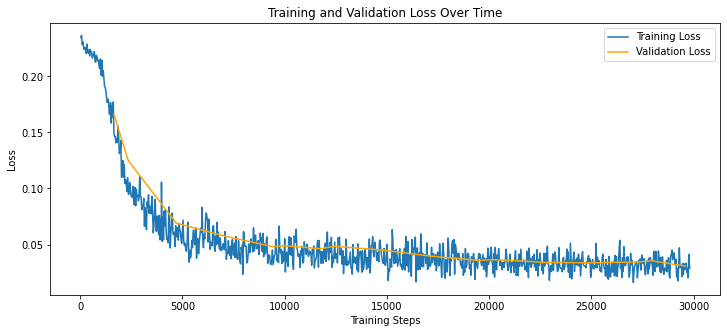

In [18]:
print(f"Length of val_losses: {len(val_losses)}")
print(f"Length of val_accs: {len(val_accs)}")

expected_validation_steps = epochs * len(train_dataloader) // test_steps
print(f"Expected number of validation steps: {expected_validation_steps}")
# Create x-axis values. Assuming validation metrics are recorded after every 'test_steps' training steps
x_values = np.arange(test_steps, epochs * test_steps + 1, step=test_steps)
x_values = np.arange(17)

# Check if x_values aligns with the length of val_losses and val_accs
plt.figure(figsize=(12, 5))

# Plot Training Loss
batches, loss = zip(*losses)
plt.plot(batches, loss, label='Training Loss')

# Plot Validation Loss
steps, val_loss = zip(*val_losses)
plt.plot(steps, val_loss, label='Validation Loss', color='orange')

# Adding labels and title
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()

plt.show()

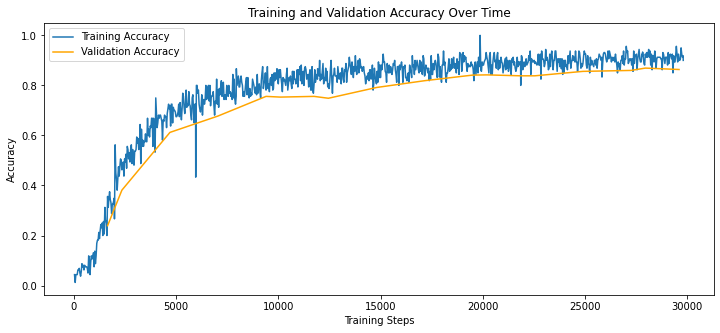

In [21]:
# Check if x_values aligns with the length of val_losses and val_accs
# print("accs: ", len(accs), "val_accs: ", len(val_accs))
plt.figure(figsize=(12, 5))

# Plot Training Accuracy
batches, loss = zip(*losses)
plt.plot(batches, accs, label='Training Accuracy')

# Plot Validation Accuracy
steps, val_loss = zip(*val_losses)
plt.plot(steps, val_accs, label='Validation Accuracy', color='orange')


# Adding labels and title
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Time')
plt.legend()

plt.show()

predicted: c truth: c
predicted: d truth: d
predicted: f truth: f
predicted: 7 truth: 7
predicted: 7 truth: 7


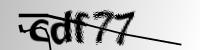

predicted: m truth: m
predicted: 4 truth: 4
predicted: g truth: g
predicted: 8 truth: 8
predicted: g truth: g


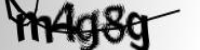

predicted: g truth: g
predicted: w truth: g
predicted: d truth: d
predicted: 7 truth: 7
predicted: m truth: m


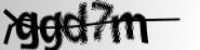

predicted: x truth: x
predicted: 2 truth: 2
predicted: c truth: c
predicted: b truth: n
predicted: n truth: n


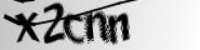

predicted: c truth: c
predicted: n truth: n
predicted: w truth: w
predicted: y truth: y
predicted: c truth: c


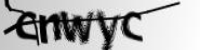

predicted: g truth: g
predicted: p truth: p
predicted: 7 truth: 7
predicted: c truth: c
predicted: 5 truth: 5


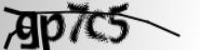

Accuracy: 92.93333333333334 %


In [20]:
total_correct = 0
total_samples = 0
for i in range(150):
    c = torch.tensor(text_captchas[-i], dtype=torch.float32)
    c = c.unsqueeze(0)
    c = c.permute(0, 3, 1, 2).to(device)
    text_captcha.eval()
    
    # predictions will be a tensor 5 x 36 x 1 (36 probabilities per prediction)
    predictions = text_captcha(c)
    
    # we change it from log probs to a softmaxed probabilities and squeeze extra dim
    predictions = [prediction.squeeze(0).softmax(0) for prediction in predictions]
    
    # instead of sampling we take the argmax
    class_ids = [prediction.argmax().item() for prediction in predictions]

    # get the scores for the argmax
    scores = [prediction[id].item() for id, prediction in zip(class_ids, predictions)]

    # map the argmaxes to human readable letters and numbers

    all_characters = string.ascii_lowercase + string.digits  # all letters of the alphabet and numbers 0-9
    vocab = {idx: char for idx, char in enumerate(all_characters)}
    
    #  total_correct += sum(pred == label for pred, label in zip(class_ids, real_ids))

    predicted_captcha = ''.join([vocab[class_id] for class_id in class_ids])
    total_samples += 5 # 5 for individual characters
    for j in range(5):
        if predicted_captcha[j] == text_labels[-i][j]:
            total_correct += 1

        if i % 25 == 0:
            print("predicted:", predicted_captcha[j], "truth:", text_labels[-i][j])
    if i % 25 == 0:
        im = Image.fromarray(text_captchas[-i].astype('uint8'), 'RGB')
        im.show(im)

print("Accuracy:", (total_correct / total_samples) * 100, "%")